<h1><center>Airborne Infection Risk Estimator for Indoor Environments
</center></h1>

<center>By Etienne Doidic, Zhexu Li, and Nicholas Kho <center>

The global pandemic of COVID-19 has demonstrated the exceptional transmissibility of the SARS-CoV-2 virus and has highlighted the vulnerability of the built environment to airborne pathogens. Building occupants and operators must now consider the dangers of airborne pathogens and enact measures to reduce the risk of airborne infection throughout buildings in order to ensure the health of occupants and the greater public. 
As buildings today reopen without a vaccine it is vital to understand the risk of airborne infection based on building features and occupant activity. It is equally vital for building operators to have detailed risk estimations so they may consider appropriate airflow for rooms when considering energy consumption.
One method that has been developed to address this situation is the infection risk calculator. These calculators allow users to input variables such as the number of occupants,  room dimensions, air change per hour (ACH), masks/no masks, etc., in order to determine the risk of infected person(s) transmitting a virus to susceptible people the room.
While these calculators may be convenient in some cases, they are “black box” algorithms, meaning the underlying code is not accessible or transparent to users. And with a large amount of skepticism surrounding the academic literature regarding this virus and its transmission [[Scheirer 2020]](https://doi.org/10.1080/00963402.2020.1778361), we believe it is important infection risk calculators are as transparent as possible. 

In this notebook we describe our methods for developing our own airborne infection risk estimator for the SARS-CoV-2 virus.

In [2]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys_path = os.path.dirname(os.getcwd())
src_path = sys_path + "/src"

sys.path.insert(1, src_path)
from calculatorv2 import * 
assumptions = var
src_path = sys_path + "/notebook"

sys.path.insert(1, src_path)


## How does it Work?

To calculate the risk of infection in a given room, the emmission rate of quanta is needed. A quantum is defined as the viral load i.e. the dose of contaminated airborne droplet nuclei required to cause infection in 63% of persons. 
The emmission rate of quanta is caclulated with the following formula:
![title](images/formula1.1.png)

[Morawska et al. 2020](https://doi.org/10.1016/j.envint.2020.105794)

<b>Ni</b> is the droplet concentrations by diameter in <b>particles per cubic centimeter</b>. The droplet concentrations are dependent on the expiratory activity of the infected person. Droplet concentrations by diameter were taken from [Morawska et al. 2009](https://doi.org/10.1016/j.jaerosci.2008.11.002). "Speaking" was considered to be the average of "singing" and "counting." 

In [2]:
pd.DataFrame(assumptions['droplet_conc'])

,speaking,counting,whispering,singing,breathing
.8μm,0.4935,0.236,0.110,0.751,0.084
1.8μm,0.1035,0.068,0.014,0.139,0.009
3.5μm,0.0730,0.007,0.004,0.139,0.003
5.5μm,0.0350,0.011,0.002,0.059,0.002


<b>cv</b> corresponds to the <b>viral load in the sputum</b> (i.e. infectious mucus) of the infected person, expressed in <b>RNA copies per mililiter</b>. The viral load in sputum of an infected person varies and is dependent on the stage of infection [[Yu et al. 2020]](https://doi.org/10.1186/s13054-020-02893-8).
A range of 1e5 - 1e9 RNA copies per mililiter for viral load in the sputum is determined but for this experiment we will choose the maximum viral load to simulate the worst case scenario for infection spread [[Walsh et al. 2020]](https://doi.org/10.1016/j.jinf.2020.06.067).

<b>ci</b> is a conversion factor defined as the ratio between one infectious quantum and the infectious dose expressed in viral RNA copies, expressed in <b>quanta per RNA copies</b>. A survey of ci's indicates a range of .01 to .1 but finally a ci of .02 was selected to reflect the average value of the infectious doses reported in [Watanabe et al. 2010](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1539-6924.2010.01427.x). The study covers SARS-CoV (not to be confused with SARS-CoV-2, the virus that causes COVID-19) but was selected because it provides a more well-studied report of the infectivity of coronaviruses, which has not possible for SARS-CoV-2 due to its very recent development.

<b>Inhalation Rate (IR)</b> is the product of breathing rate and tidal volume, expressed in <b>cubic meters per hour</b>. IR is dependent on the activity of the infected subject. The following values were chosen from [Adams 1993](https://ww2.arb.ca.gov/sites/default/files/classic//research/apr/past/a033-205.pdf)


Next we must calculate the quanta concentration as a function of time using the following equation:
![title](images/formula1.png)
[Gammaitoni, Nucci 1997](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2627642/)

where <b>IVRR (hr−1)</b> represents the infectious virus removal rate in the space investigated. The infectious virus removal rate (IVRR) is the sum of three parameters [(Yang and Marr, 2011)](https://doi.org/10.1371/journal.pone.0021481): the air change per hour (<b>ACH</b>) via ventilation, the <b>particle deposition</b> on surfaces via gravitational settling, and the <b>viral inactivation rate</b> (i.e. how long the virus remains contagious in aerosol).

<b>n0</b> represents the initial number of quanta in the space

<b>I</b> is the number of infectious subjects, 

<b>V</b> is the volume of the indoor environment considered,

and <b>ERq</b> is the abovementioned quanta emission rate (quanta h−1)

This model was selected because it has been used in previous papers to estimate infection risk of other airborne diseases in indoor environments. For example [Wagner et al. 2009](https://bmcmedicine.biomedcentral.com/articles/10.1186/1741-7015-7-81)

The <b>viral inactivation rate</b> of SARS-CoV2 was determined to be .63 by [Doremalen et al. 2020](https://doi.org/10.1056/nejmc2004973).

<b>Deposition rate</b> is determined by the ratio of the settling velocity of the micrometric particles (1e-4 m/s) and 
assuming the height of the emmission source. Given the average height of a person is 1.5 m, the deposition_rate is assumed to be .24 per hour [(Chatoutsidou and Lazaridis, 2019)](https://doi.org/10.1016/j.culher.2019.02.017)

<b>ACH</b> is dependent on room conditions. Is a window open? Is the air conditioning pushing in new air? In order to determine the ACH we use the flow rate of the VAV inside of the room. VAV flow rates were determined using VAV spec sheets.

<b>n0</b> or initial quanta is assumed to be zero in our experiment. This is because there doesn't seem to be an accurate way of determining this value. Assuming a natural ventilation ACH of .2, the IVRR would be 1.02(hr-1) meaning that in a little under an hour any viral particles would be inactive. So for the sake of this experiment we will assume the room has been empty for about an hour beforehand. 

Finally, to determine the the number of predicted susceptible people infected after the exposure time, we must find the product of the infection risk R and the number of susceptible people. 
To find R, we use the function below
![title](images/formula3.png)

## Let's Try Out Some Estimations

The function get_quanta_emmission_rate accepts a physical activity and an exipratory activity and a dictionary of assumptions to determine the emission rate of quanta coming from one infected person. 

In [3]:
#Emmission Rates based on activity using the Morawska et al. equation
ERq1 = get_quanta_emmission_rate('heavy_exercise', 'singing',assumptions)
ERq2 = get_quanta_emmission_rate('resting', 'whispering', assumptions)
print('Emission rate in quanta per hour for an infected person exercising and singing: ' + str(ERq1))
print('                                 for an infected person resting and whispering: ' + str(ERq2))

Emission rate in quanta per hour for an infected person exercising and singing: 429.40479084296925
                                 for an infected person resting and whispering: 2.207333975988981


Lets compare how quanta concentration changes over time given the ASHRAE standard airflow for a room of this type and no ventilation at all. 

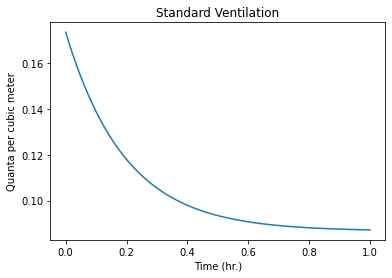

In [4]:
#Now lets estimate quanta concentration
room = get_room_data(sys_path + '/data/masterBuildingData.csv', 'Center Hall', '101')
ach = get_air_changes_per_hour(room['ASHRAE_Airflow'], room['Volume'])
ivrr = .63 + .24 + ach
def quanta_concentration(t, I = 1, ERq = ERq1, V = room['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('Standard Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, 1)
ax.plot(x, f2(x));

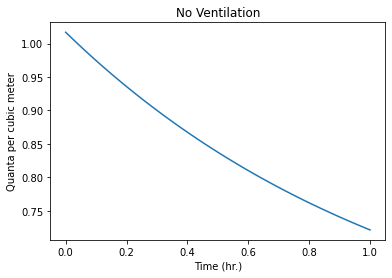

In [5]:
ivrr = .63 + .24
def quanta_concentration(t, I = 1, ERq = ERq1, V = room['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('No Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, 1)
ax.plot(x, f2(x));

We can see that ventilation can mean the difference between exponential decay of pathogen concentration and linear decay of pathogen concentration. 

Now lets make risk estimations for a simulated event. Lets assume the event is 1.5 hours long, it will occur in Center Hall 101 and it will include 50 people who will be walking around, sitting, speaking and whispering without masks and the airflow set to the ASHRAE recommended standard.
We can find the risk of airborne infection for this event by finding the average of two events with these parameters. 

In [7]:
#Infection Risk
walking_talking_risk = infection_risk(1.5, 'Center Hall', '101', 50, 'light_exercise', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')
sitting_whisper_risk = infection_risk(1.5, 'Center Hall', '101', 50, 'resting', 'whispering',False, 'recommended', sys_path + '/data/masterBuildingData.csv')
average_risk = (walking_talking_risk + sitting_whisper_risk) /2

It is estimated that an individual has 2.480504942982409% chance to be infected
It is estimated that an individual has 0.02073084910051426% chance to be infected


In [8]:
average_risk

0.012506178960414616

Now we can determine the "riskiest" activities

It is estimated that an individual has 0.22285722611271597% chance to be infected
It is estimated that an individual has 0.27059402794856746% chance to be infected
It is estimated that an individual has 1.7540425442991503% chance to be infected
It is estimated that an individual has 5.002177964381471% chance to be infected
It is estimated that an individual has 9.624064015586221% chance to be infected


<BarContainer object of 5 artists>

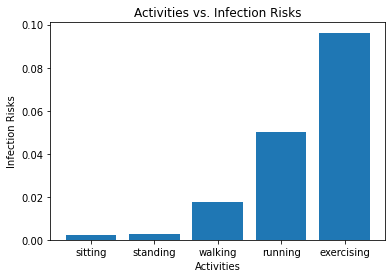

In [16]:
t = 1
sitting_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'resting', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')
standing_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')
walking_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'light_exercise', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

running_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'moderate_exercise', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

exercising_talking_risk = infection_risk(t, 'Center Hall', '101', 50, 'heavy_exercise', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Activities')
plt.ylabel('Infection Risks')
plt.title('Activities vs. Infection Risks')
actno = ["sitting", "standing", "walking", "running", "exercising"]
risks = [sitting_talking_risk, standing_talking_risk, walking_talking_risk, running_talking_risk, exercising_talking_risk]
ax.bar(actno, risks)

It is estimated that an individual has 0.27059402794856746% chance to be infected
It is estimated that an individual has 0.07310923392100932% chance to be infected
It is estimated that an individual has 0.017738345210016604% chance to be infected
It is estimated that an individual has 0.4676885342010051% chance to be infected
It is estimated that an individual has 0.015381204623698963% chance to be infected


<BarContainer object of 5 artists>

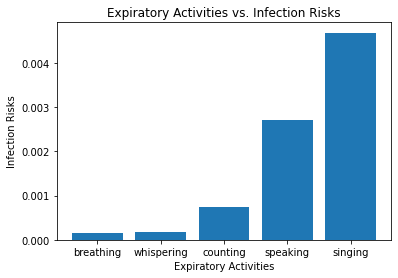

In [17]:
speaking = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'speaking', False, 'recommended', sys_path + '/data/masterBuildingData.csv')
counting = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'counting', False, 'recommended', sys_path + '/data/masterBuildingData.csv')
whispering = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'whispering', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

singing = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'singing', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

breathing = infection_risk(t, 'Center Hall', '101', 50, 'standing', 'breathing', False, 'recommended', sys_path + '/data/masterBuildingData.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Expiratory Activities')
plt.ylabel('Infection Risks')
plt.title('Expiratory Activities vs. Infection Risks')
actno = ["breathing", "whispering", "counting", "speaking", "singing"]
risks = [breathing, whispering, counting, speaking, singing]
ax.bar(actno, risks)

## Model: Results and Discussion

The purpose of this calculator is to give building users a better understanding of how infection can be spread. Our findings give insight into effective methods for mitigating infection risk in indoor environments. A significant driver in infection risk is the type of physical activity. Heavier breathing increases risk of infection exponentially. Likewise more intense expiratory activity like speaking loudly or singing would increase risk of infection. A large factor in risk mitigation is ventilation. No ventilation at all, we observed, causes a linear decrease in quanta concentration, while minimal ventilation will produce an exponential decrease in concentration. 

The effect of social distancing and mask wearing was not directly addressed by this model. Social distancing was indirectly addressed by the assumed 1.5m (>6ft) distance from the emission source in calculating deposition rate. The effect of masks on this model will require further research. 

This model could be further improved by more accurately depicting the cyclical nature of building airflow. Currently our model assumes that room airflow systems have a constant source of airflow, but in reality building airflow systems tend to expell long bursts of fresh air and then stop for a period of time.   

## Building Data

In order for the risk estimator tool to be useful and easy to use for the average UC San Diego user, they should be able to select a building and room and have the room area, volume, and airflow ranges automatically inputted into their estimation. 
To make this possible, room data was downloaded from the campus database. Because currently the range of variable airflow volume (VAV) is currently not available for all rooms, and would require a lengthy manual process for finding and validating VAV setpoint range, each room was assigned an ASHRAE standard airflow based on the room type which is used for calculating quanta concentration over time. 

## Website
You can view our website here: https://hinanawits.github.io/DSC-180B-Presentation-Website/

On this website users will select the building, room, VAV level, any additional air cleaning methods like air purifiers, the duration of the event, number of occupants, the anticipated activity of the occupants and masks/no masks. Then the website will display the estimated risk as a bar charts, which allows the user to visualize the relative differences in risk associated with different event/airflow parameters.  There is also an option to add custom rooms, where a user can upload their own .csv's to add rooms to the dataset. Users also have the ability to alter the assumptions in the calculator in order to have more up-to-date values as more literature is published regarding COVID-19. Methods are included in our website so those interested can follow step-by-step how the estimator reaches its conclusions. 

The final result is an open-source easy-to-use website that appeals to everyday users who want peace of mind when entering a room, or need a reference when planning events; and more advanced users like building operators or developers who want more control over the model. 

## Future Work

With more information regarding real VAV ranges for buildings on campus being released, the estimations will become more accurate. 
Further integration with building operating systems would allow more accurate risk estimations. As building occupancy detection methods improve, this model could be used to update VAV setpoints in real time in order to mitigate airborne infections. 